In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d
import cv2
import random 

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
dtype = torch.cuda.FloatTensor

In [3]:
preprocess = T.Compose([
    T.ToPILImage(),
    T.Resize([224,224]),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
    T.Lambda(lambda x : x[None , :])
])

In [4]:
sqnet = models.squeezenet1_1(pretrained=True).type(dtype)
sqnet.eval()

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [4]:
im = cv2.imread("cat_horror.png")
im = cv2.cvtColor(im , cv2.COLOR_BGR2RGB)
im = preprocess(im)
im.shape

torch.Size([1, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

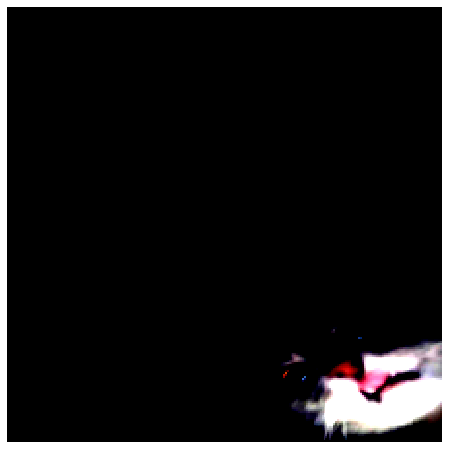

In [5]:
plt.imshow(np.transpose(im.detach().numpy()[0] , (1,2,0)))
plt.axis("off")

In [6]:
im.requires_grad_(True)
r = sqnet(im)

In [7]:
s2 = r.max()

In [8]:
s2

tensor(13.4109, grad_fn=<MaxBackward1>)

In [9]:
s2.backward()

(-0.5, 223.5, 223.5, -0.5)

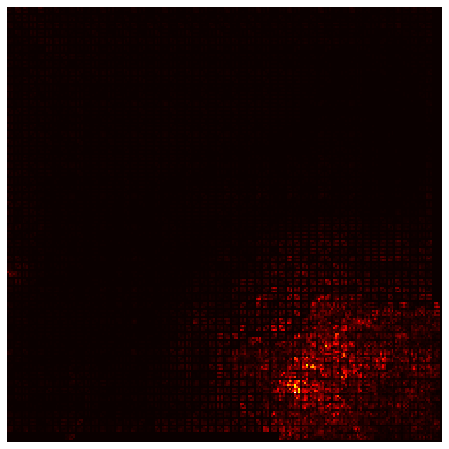

In [10]:
saliency, _ = torch.max(im.grad.data.abs(), dim=1)
saliency = saliency.numpy()
plt.imshow(saliency[0] , cmap=plt.cm.hot)
plt.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


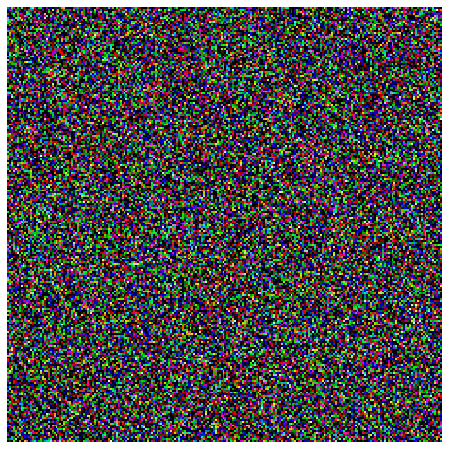

In [5]:
noise_img = torch.FloatTensor(1,3,224,224).uniform_(-1,1).type(dtype).requires_grad_(True)
plt.imshow(np.transpose(noise_img[0].detach().cpu().numpy() , (1,2,0)))
plt.axis("off")
SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

In [8]:
def jitter(X, ox, oy):
    """
    Helper function to randomly jitter an image.
    
    Inputs
    - X: PyTorch Tensor of shape (N, C, H, W)
    - ox, oy: Integers giving number of pixels to jitter along W and H axes
    
    Returns: A new PyTorch Tensor of shape (N, C, H, W)
    """
    if ox != 0:
        left = X[:, :, :, :-ox]
        right = X[:, :, :, -ox:]
        X = torch.cat([right, left], dim=3)
    if oy != 0:
        top = X[:, :, :-oy]
        bottom = X[:, :, -oy:]
        X = torch.cat([bottom, top], dim=2)
    return X

def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

In [10]:
max_jitter = 16
blur_every = 10

for i in range(500):
    ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
    noise_img.data.copy_(jitter(noise_img , ox , oy))
    
    if i%20 == 0:
        print(f"Iter: {i}")
    o = sqnet(noise_img)
    s = o[: , 187] - torch.norm(noise_img)*1e-3
    s.backward()
    noise_img.data += (25*noise_img.grad.data/torch.norm(noise_img.grad.data))
    noise_img.grad.data.zero_()
    
    noise_img.data.copy_(jitter(noise_img , -ox , -oy))
    
    for c in range(3):
        lo = float(-SQUEEZENET_MEAN[c] / SQUEEZENET_STD[c])
        hi = float((1.0 - SQUEEZENET_MEAN[c]) / SQUEEZENET_STD[c])
        noise_img.data[:, c].clamp_(min=lo, max=hi)
    
    if i % blur_every == 0:
            blur_image(noise_img.data, sigma=0.5)

Iter: 0
Iter: 20
Iter: 40
Iter: 60
Iter: 80
Iter: 100
Iter: 120
Iter: 140
Iter: 160
Iter: 180
Iter: 200
Iter: 220
Iter: 240
Iter: 260
Iter: 280
Iter: 300
Iter: 320
Iter: 340
Iter: 360
Iter: 380
Iter: 400
Iter: 420
Iter: 440
Iter: 460
Iter: 480


In [17]:
plt.imshow(np.transpose(noise_img[0].detach().cpu().numpy() , (1,2,0)))
plt.axis("off")

TypeError: 'Image' object is not subscriptable

In [118]:
noise_img.max()

tensor(2.6400, device='cuda:0', grad_fn=<MaxBackward1>)

In [89]:
noise_img = (noise_img - noise_img.mean())/noise_img.std()

In [98]:
noise_img = T.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])(noise_img[0])

In [109]:
n2 = (noise_img - noise_img.min()).clamp(max=255)

In [14]:
def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        T.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

In [16]:
n2 = deprocess(noise_img.data.cpu())

(-0.5, 223.5, 223.5, -0.5)

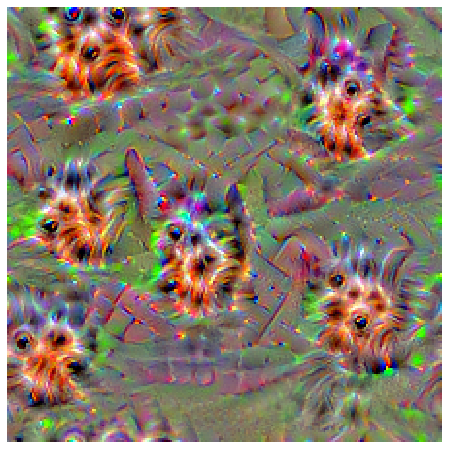

In [18]:
plt.imshow(n2)
plt.axis("off")